# Predicting Breast Cancer Survival Time: Random Survival Forest Model

Dataset: Supplementary Data 3 in the following link: https://www.nature.com/articles/s41523-021-00319-4#MOESM5 

### Import Necessary Libraries

In [109]:
# Predicting Breast Cancer Survival Time: Random Survival Forest Model

# Importing Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

%matplotlib inline

### Load Data

In [110]:
# Loading dataset
df = pd.read_csv("breast_cancer_data_ML.csv")

## Exploratory Data Analysis

### Understanding Columns

#### Features in the Dataset

- **Patient ID:** Identifier, not feature for prediction.
- **Mutation:** Genetic mutations present in cancerous cells (e.g., PTEN, TP53, PIK3CA) which can influence the aggressiveness of the cancer and potential response to therapy.
- **MAF of Gene at Baseline and 4 Weeks:** Measures the mutation allele frequency (MAF) at baseline and after 4 weeks, providing insights into the genetic evolution of the tumor under treatment.
- **CTCs Counts at Baseline and 4 Weeks:** Circulating tumor cells (CTCs) can indicate the extent of tumor burden and might predict metastasis.
- **Age:** Age of the patient at diagnosis, which is a known risk factor in breast cancer prognosis.
- **PS (Performance Status):** A measure of how the disease affects a patient's daily living abilities; lower scores typically indicate better functioning.
- **Metastatic Site:** The location of metastases can influence prognosis; for example, visceral metastases are often associated with poorer outcomes compared to bone metastases.
- **Number of Metastatic Sites:** Indicates disease burden; more sites can correlate with a more advanced or aggressive disease.
- **Subtype:** Breast cancer subtype (e.g., Triple Negative, RH+) which is crucial for determining treatment strategy and prognosis.
- **Tumor Grade:** Indicates the aggressiveness of the tumor based on how much the cancer cells differ from healthy cells.
- **OS (Overall Survival) at Baseline and OS from Weeks 4:** Survival time from the initial diagnosis and from week 4 respectively.
- **Status OS:** The status (e.g., alive, deceased) at the last follow-up, potentially used as a target variable for survival analysis.
- **PFS (Progression-Free Survival) at Baseline and PFS from Weeks 4:** Time during and after the treatment that the patient lives without the disease worsening.
- **Status PFS:** Similar to Status OS, indicates whether the disease has progressed as of the last follow-up.
- **Menopausal Status:** Hormonal status can impact the disease's behavior and treatment responses.
- **MFI (Metastatic Free Interval):** Time between initial diagnosis and the development of metastases.
- **Metastatic Sites:** Specific sites where metastases are present, which could be critical for prognosis.
- **Histology:** The study of the tissue origin and structure of the cancer; certain histological types may be more aggressive.

#### Checking for missing values

In [111]:
# Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient                       198 non-null    int64  
 1   Mutation                      198 non-null    object 
 2   MAF of gene used at baseline  198 non-null    float64
 3   MAF of gene used at 4 weeks   191 non-null    float64
 4   CTCs counts at baseline       198 non-null    int64  
 5   CTCs counts at 4 weeks        196 non-null    float64
 6   AGE                           198 non-null    int64  
 7   PS                            198 non-null    int64  
 8   metastatic site               197 non-null    object 
 9   N of met. Sites               197 non-null    object 
 10  subtype                       198 non-null    object 
 11  Tumor grade                   181 non-null    object 
 12  OS at baseline                198 non-null    int64  
 13  Statu

#### Update: Missing values detected (see above)

Breakdown of where missing values are:

- MAF of gene used at 4 weeks: Out of 198 entries, only 191 are non-null. This means there are 7 missing values in this column.

- CTCs counts at 4 weeks: 196 non-null entries suggest 2 missing values.

- metastatic site: With 197 non-null entries, there is 1 missing value.

- N of met. Sites: Similarly, with 197 non-null entries, there is 1 missing value.

- Tumor grade: There are 17 missing values since only 181 out of 198 entries are non-null.

- meno.status: This has 2 missing values, with 196 non-null entries.

- MFI: There are 4 missing values, as it has 194 non-null entries.

- Met.sites: This also indicates 1 missing value, with 197 non-null entries.

- Histology: There are 3 missing values, with 195 non-null entries.

Handling of missing values is required before analysis can proceed. Techniques such as imputation, removal, or substitution, can be used depending on significance of data and the intended analysis.

#### Figure 1: Count of Survival Status

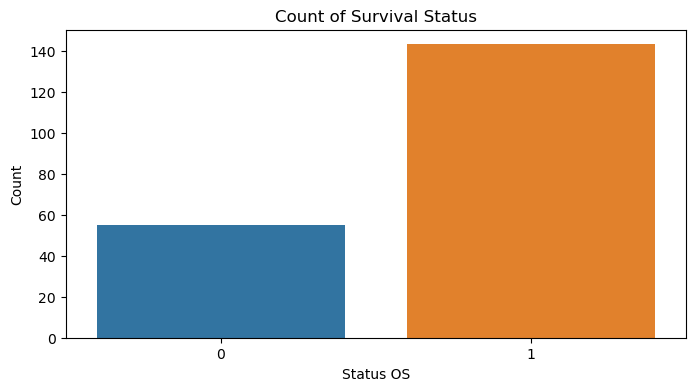

Status OS
1    143
0     55
Name: count, dtype: int64


In [112]:
# Exploratory Data Analysis
# Figure 1: Count of Survival Status
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure for plotting
plt.figure(figsize=(8, 4))

# Plotting 'Status OS' counts
sns.countplot(x=df["Status OS"])

# Adding title and labels to improve clarity
plt.title('Count of Survival Status')
plt.xlabel('Status OS')
plt.ylabel('Count')

# Display the plot
plt.show()

# Printing the value counts of 'Status OS'
target_status_OS = df["Status OS"].value_counts()
print(target_status_OS)

#### Figure 2:

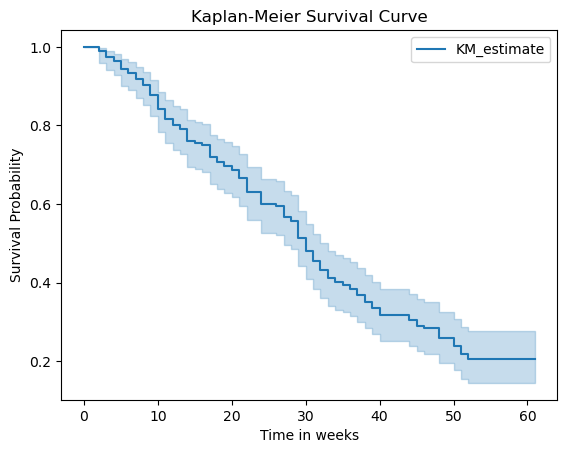

In [113]:
# Exploratory Data Analysis
# Figure 2: Kaplan Meier Curve Overall
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Inititative KaplanMeierFitter model
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df["OS from weeks 4"], event_observed=df["Status OS"])

# Plot the KM survival curve
kmf.plot_survival_function()

# Add title and labels
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time in weeks')
plt.ylabel('Survival Probability')

# Show plot
plt.show()

#### Table 1: Mutation Counts

In [114]:
# Exploratory Data Analysis
# Table 1: Mutation Counts
import pandas as pd
df = pd.read_csv("breast_cancer_data_ML.csv")

mutation_counts = df['Mutation'].value_counts()

print(mutation_counts)

Mutation
No mutated    51
TP53          42
PIK3CA        34
GATA3          9
ESR1           9
PTEN           6
ARID1A         4
KMT2C          4
BRCA1          4
GNAS           3
CDH1           3
SF3B1          3
RUNX1T1        2
NOTCH2         2
MAP3K1         2
NCOR1          2
KRAS           2
MAP2K4         2
ERBB2          2
CDKN2A         2
BRCA2          1
RB1            1
NF1            1
MDM4           1
CTNNB1         1
MYC            1
AR             1
ZNF217         1
RUNX1          1
ERBB3          1
Name: count, dtype: int64


#### Figure 3: Tumor Grade Distribution

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

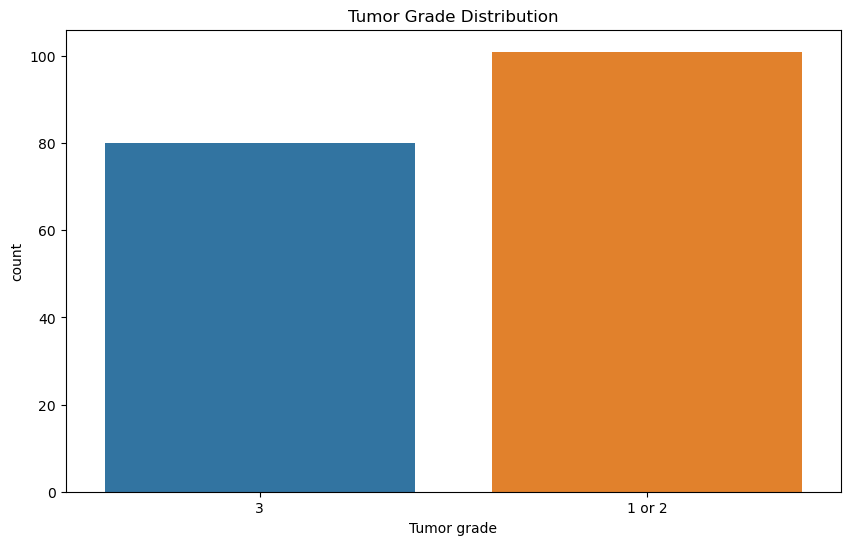

In [115]:
# Exploratory Data Analysis
# Figure 3: Tumor Grade Distribution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Custom labels for the x-axis
custom_labels = ['No Tumour', 'Grade 1 or 2', 'Grade 3']

# Plot 7: Tumor Grade Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Tumor grade', data=df)
ax.set_title('Tumor Grade Distribution')
ax.set_xticklabels(custom_labels)
plt.show()

#### Figure 4: Kaplan-Meier Survival Curves for "No mutation" and "TP53 and PIK3CA Mutation" Groups

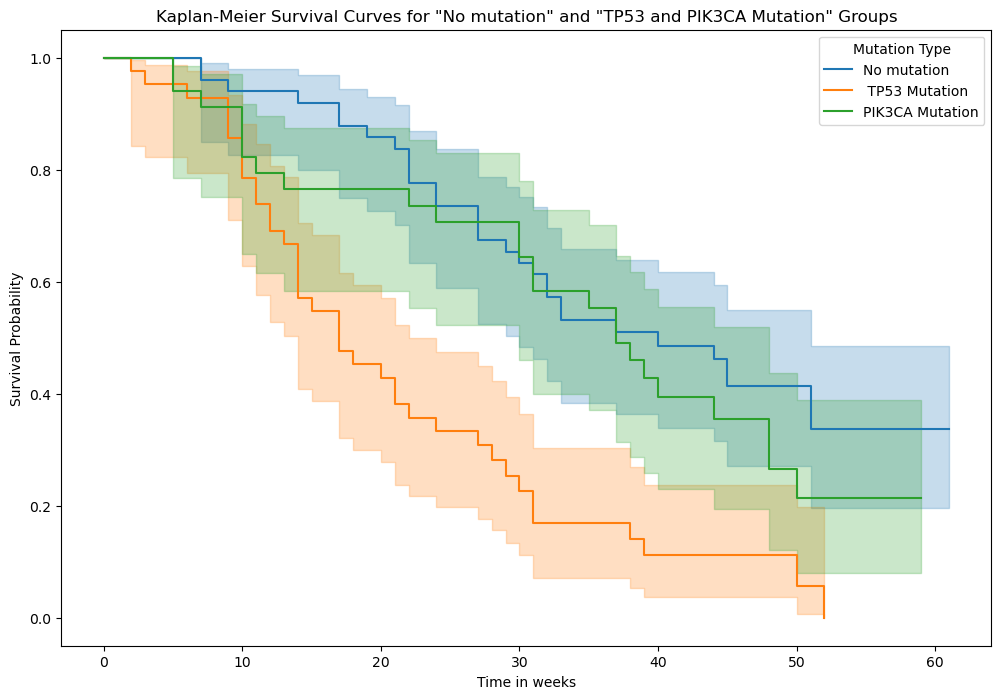

In [116]:
# Exploratory Data Analysis
# Figure 4: Kaplan-Meier Survival Curves for "No mutation" and "TP53 and PIK3CA Mutation" Groups
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

no_mutation = df[df['Mutation'] == 'No mutated']
TP53 = df[df['Mutation'] == 'TP53']
PIK3CA = df[df['Mutation'] == 'PIK3CA']
GATA3 = df[df['Mutation'] == 'GATA3']
ESR1 = df[df['Mutation'] == 'ESR1']

# Inititative KaplanMeierFitter model
kmf_no_mutation = KaplanMeierFitter()
kmf_TP53 = KaplanMeierFitter()
kmf_PIK3CA = KaplanMeierFitter()
kmf_GATA3 = KaplanMeierFitter()
kmf_ESR1 = KaplanMeierFitter()

# Plotting
plt.figure(figsize=(12, 8))

# Fit the model for the "No mutation" group
kmf_no_mutation.fit(durations=no_mutation["OS from weeks 4"], event_observed=no_mutation["Status OS"], label='No mutation')
kmf_no_mutation.plot_survival_function()

# Fit the model for the "TP53" group
kmf_TP53.fit(durations=TP53["OS from weeks 4"], event_observed=TP53["Status OS"], label=' TP53 Mutation')
kmf_TP53.plot_survival_function()

# Fit the model for the "PIK3CA" group
kmf_PIK3CA.fit(durations=PIK3CA["OS from weeks 4"], event_observed=PIK3CA["Status OS"], label='PIK3CA Mutation')
kmf_PIK3CA.plot_survival_function()

# Add title and labels
plt.title('Kaplan-Meier Survival Curves for "No mutation" and "TP53 and PIK3CA Mutation" Groups')
plt.xlabel('Time in weeks')
plt.ylabel('Survival Probability')

# Show legend
plt.legend(title='Mutation Type')

# Show plot
plt.show()

#### Figure 5: Kaplan-Meier Curve (TP53, PIK3CA, GATA3, ESR1, Vs. No Mutation

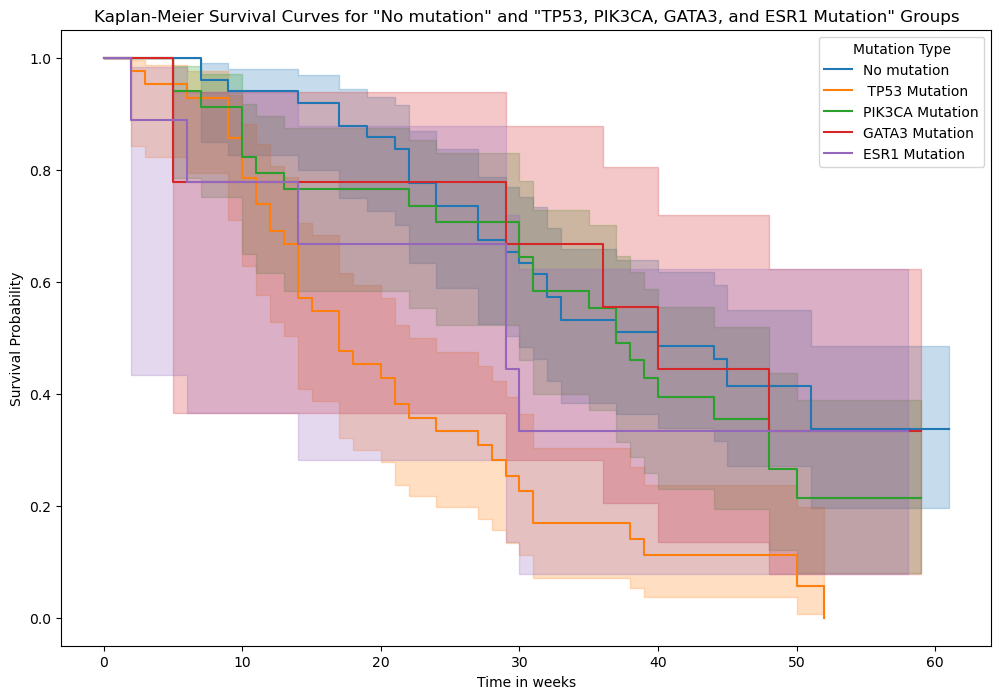

In [117]:
# Exploratory Data Analysis
# Figure 5: Kaplan-Meier Curve (TP53, PIK3CA, GATA3, ESR1, Vs. No Mutation
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

no_mutation = df[df['Mutation'] == 'No mutated']
TP53 = df[df['Mutation'] == 'TP53']
PIK3CA = df[df['Mutation'] == 'PIK3CA']
GATA3 = df[df['Mutation'] == 'GATA3']
ESR1 = df[df['Mutation'] == 'ESR1']

# Inititative KaplanMeierFitter model
kmf_no_mutation = KaplanMeierFitter()
kmf_TP53 = KaplanMeierFitter()
kmf_PIK3CA = KaplanMeierFitter()
kmf_GATA3 = KaplanMeierFitter()
kmf_ESR1 = KaplanMeierFitter()

# Plotting
plt.figure(figsize=(12, 8))

# Fit the model for the "No mutation" group
kmf_no_mutation.fit(durations=no_mutation["OS from weeks 4"], event_observed=no_mutation["Status OS"], label='No mutation')
kmf_no_mutation.plot_survival_function()

# Fit the model for the "TP53" group
kmf_TP53.fit(durations=TP53["OS from weeks 4"], event_observed=TP53["Status OS"], label=' TP53 Mutation')
kmf_TP53.plot_survival_function()

# Fit the model for the "PIK3CA" group
kmf_PIK3CA.fit(durations=PIK3CA["OS from weeks 4"], event_observed=PIK3CA["Status OS"], label='PIK3CA Mutation')
kmf_PIK3CA.plot_survival_function()

# Fit the model for the "GATA3" group
kmf_GATA3.fit(durations=GATA3["OS from weeks 4"], event_observed=GATA3["Status OS"], label='GATA3 Mutation')
kmf_GATA3.plot_survival_function()

# Fit the model for the "ESR1" group
kmf_ESR1.fit(durations=ESR1["OS from weeks 4"], event_observed=ESR1["Status OS"], label='ESR1 Mutation')
kmf_ESR1.plot_survival_function()

# Add title and labels
plt.title('Kaplan-Meier Survival Curves for "No mutation" and "TP53, PIK3CA, GATA3, and ESR1 Mutation" Groups')
plt.xlabel('Time in weeks')
plt.ylabel('Survival Probability')

# Show legend
plt.legend(title='Mutation Type')

# Show plot
plt.show()

#### Figure 6: Kaplan-Meier Curve of No Mutation Vs. Mutation

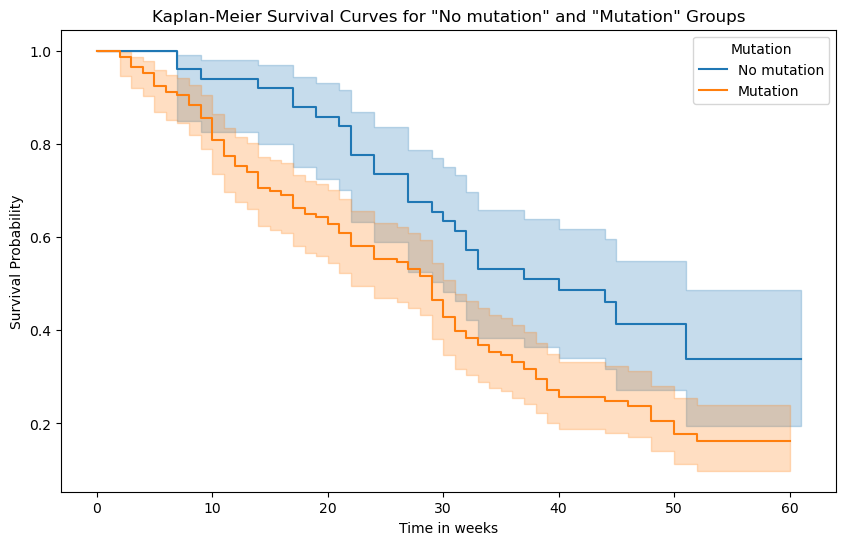

In [118]:
# Exploratory Data Analysis
# Figure 6: Kaplan-Meier Curve of No Mutation Vs. Mutation

# Filter the DataFrame to include only rows where Mutation is "No mutated"
no_mutated_df = df[df['Mutation'] == 'No mutated']

# Filter the DataFrame to include only rows where Mutation is not "No mutated"
mutated_df = df[df['Mutation'] != 'No mutated']

# Initialize KaplanMeierFitter model
kmf_no_mutated = KaplanMeierFitter()
kmf_mutated = KaplanMeierFitter()

# Plotting
plt.figure(figsize=(10, 6))

# Fit the model for the "No mutated" group
kmf_no_mutated.fit(durations=no_mutated_df["OS from weeks 4"], event_observed=no_mutated_df["Status OS"], label='No mutation')
kmf_no_mutated.plot_survival_function()

# Fit the model for the "mutated" group
kmf_mutated.fit(durations=mutated_df["OS from weeks 4"], event_observed=mutated_df["Status OS"], label='Mutation')
kmf_mutated.plot_survival_function()

# Add title and labels
plt.title('Kaplan-Meier Survival Curves for "No mutation" and "Mutation" Groups')
plt.xlabel('Time in weeks')
plt.ylabel('Survival Probability')

# Show legend
plt.legend(title='Mutation')

# Show plot
plt.show()

#### Figure 7: Kaplan-Meier Survival Curves for "No Visceral" and "Visceral" Groups

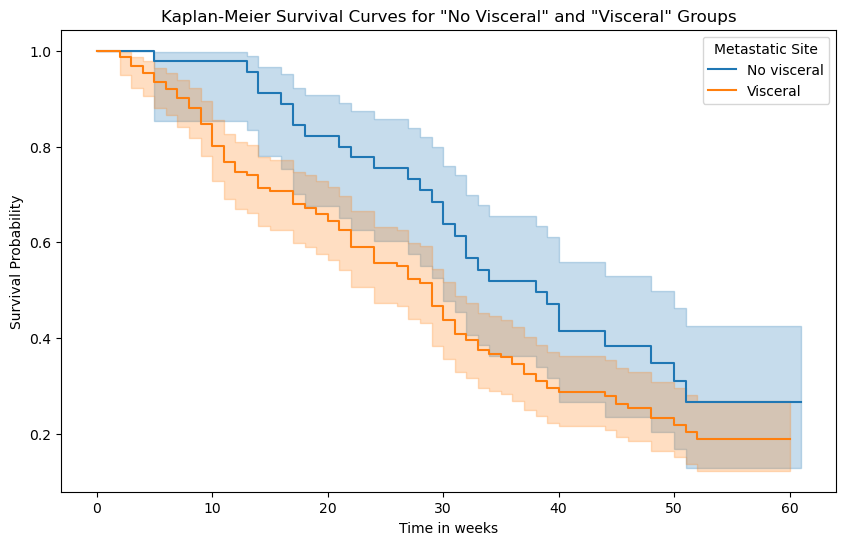

In [119]:
# Exploratory Data Analysis
# Figure 7: Kaplan-Meier Survival Curves for "No Visceral" and "Visceral" Groups

# Filter the DataFrame to include only rows where metastatic site is "No visceral"
no_visceral_df = df[df['metastatic site'] == 'No visceral']

# Filter the DataFrame to include only rows where metastatic site is "Visceral"
visceral_df = df[df['metastatic site'] == 'Visceral']

# Initialize KaplanMeierFitter model
kmf_no_visceral = KaplanMeierFitter()
kmf_visceral = KaplanMeierFitter()

# Plotting
plt.figure(figsize=(10, 6))

# Fit the model for the "No visceral" group
kmf_no_visceral.fit(durations=no_visceral_df["OS from weeks 4"], event_observed=no_visceral_df["Status OS"], label='No visceral')
kmf_no_visceral.plot_survival_function()

# Fit the model for the "Visceral" group
kmf_visceral.fit(durations=visceral_df["OS from weeks 4"], event_observed=visceral_df["Status OS"], label='Visceral')
kmf_visceral.plot_survival_function()

# Add title and labels
plt.title('Kaplan-Meier Survival Curves for "No Visceral" and "Visceral" Groups')
plt.xlabel('Time in weeks')
plt.ylabel('Survival Probability')

# Show legend
plt.legend(title='Metastatic Site')

# Show plot
plt.show()

#### Figure 8: Kaplan-Meier Survival Curves for "Triple Negative" and "RH+" Groups

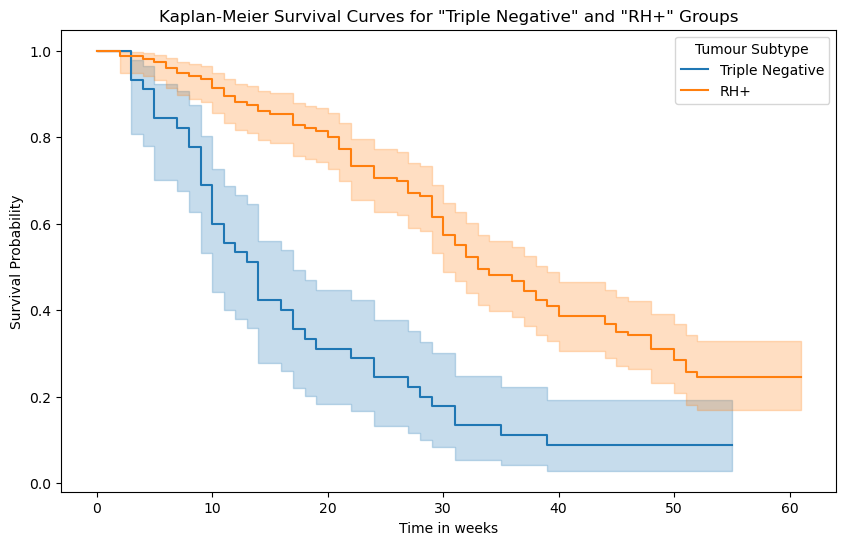

In [120]:
# Exploratory Data Analysis
# Figure 8: Kaplan-Meier Survival Curves for "Triple Negative" and "RH+" Groups
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows where metastatic site is "No visceral"
triple_negative_df = df[df['subtype'] == 'Triple negative']

# Filter the DataFrame to include only rows where metastatic site is "Visceral"
rh_plus_df = df[df['subtype'] == 'RH+']

# Initialize KaplanMeierFitter model
kmf_triple_negative = KaplanMeierFitter()
kmf_rh_plus = KaplanMeierFitter()

# Plotting
plt.figure(figsize=(10, 6))

# Fit the model for the "No visceral" group
kmf_triple_negative.fit(durations=triple_negative_df["OS from weeks 4"], event_observed=triple_negative_df["Status OS"], label='Triple Negative')
kmf_triple_negative.plot_survival_function()

# Fit the model for the "Visceral" group
kmf_rh_plus.fit(durations=rh_plus_df["OS from weeks 4"], event_observed=rh_plus_df["Status OS"], label='RH+')
kmf_rh_plus.plot_survival_function()

# Add title and labels
plt.title('Kaplan-Meier Survival Curves for "Triple Negative" and "RH+" Groups')
plt.xlabel('Time in weeks')
plt.ylabel('Survival Probability')

# Show legend
plt.legend(title='Tumour Subtype')

# Show plot
plt.show()

#### Feature Engineering: Tumor Grade

In [121]:
# Feature Engineering: Tumor Grade
# converting tumor 1 or 2 to 1.5 to average between 2 guesses.
df["Tumor grade"] = df["Tumor grade"].replace('1 or 2',1.5)

df["Tumor grade"] = pd.to_numeric(df["Tumor grade"], errors='coerce')

In [122]:
df['Tumor grade'].head(10)

0    3.0
1    1.5
2    3.0
3    1.5
4    3.0
5    3.0
6    1.5
7    NaN
8    1.5
9    3.0
Name: Tumor grade, dtype: float64

In [123]:
# Create an imputer to fill missing values with 0.1
# imputer = SimpleImputer(strategy='constant', fill_value=0.1)

# Apply the imputer to the "Tumor grade" column
# df['Tumor grade'] = imputer.fit_transform(df[['Tumor grade']])

In [124]:
df = df.dropna(subset=['Tumor grade'])

In [125]:
print(df['Tumor grade'].isna().sum())  # Should output 0

0


In [126]:
df['Tumor grade'].head(10)

0     3.0
1     1.5
2     3.0
3     1.5
4     3.0
5     3.0
6     1.5
8     1.5
9     3.0
10    1.5
Name: Tumor grade, dtype: float64

In [127]:
print(df['Tumor grade'])

0      3.0
1      1.5
2      3.0
3      1.5
4      3.0
      ... 
193    3.0
194    1.5
195    3.0
196    1.5
197    3.0
Name: Tumor grade, Length: 181, dtype: float64


In [128]:
# Convert the column to int64
# df['Tumor grade'] = df['Tumor grade'].astype('int64')

# Convert 'Tumor grade' to int64
# df['Tumor grade'] = df['Tumor grade'].astype('int64')

In [129]:
df['Tumor grade'].head(50)

0     3.0
1     1.5
2     3.0
3     1.5
4     3.0
5     3.0
6     1.5
8     1.5
9     3.0
10    1.5
11    1.5
12    3.0
13    3.0
14    1.5
16    1.5
17    3.0
18    3.0
19    1.5
20    3.0
21    3.0
22    1.5
23    1.5
24    3.0
25    1.5
26    1.5
27    3.0
28    1.5
29    1.5
30    3.0
31    1.5
32    1.5
33    1.5
34    1.5
35    1.5
36    1.5
38    3.0
39    3.0
40    1.5
41    3.0
42    1.5
43    1.5
44    3.0
45    3.0
46    1.5
47    3.0
49    1.5
50    3.0
51    3.0
52    3.0
53    3.0
Name: Tumor grade, dtype: float64

#### Feature Engineering: No. of Metastatic Sites

In [130]:
# Map 'N of met. Sites' to numeric values
df['N of met. Sites numeric'] = df['N of met. Sites'].map({'< 3': 0, '>=3': 1})

In [131]:
# Verify the conversion
print(df[['N of met. Sites', 'N of met. Sites numeric']].head())

  N of met. Sites  N of met. Sites numeric
0             < 3                      0.0
1             < 3                      0.0
2             < 3                      0.0
3             >=3                      1.0
4             >=3                      1.0


### Step 1: Preprocessing Data

#### Select Relevant Features for Model

In [132]:
# Step 1: Preprocessing Data
# Select Relevant Features for model
features = df [['AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline', 'subtype', 'metastatic site', 'Tumor grade', 'N of met. Sites numeric']]
target = df[['Status OS', 'OS at baseline']] 

# [[selects multiple columns]], result is a dataframe.
# [selects a single column], result is a series.

#### Define Preprocesssing for Numeric and Categorical Variables

In [133]:
# Define Preprocessing for Numberic and Categorical Variables

# List of numeric features which will be included in model
numeric_features = ['AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline', 'Tumor grade']

# List of categorical features which will be included in model
categorical_features = ['subtype', 'metastatic site', 'N of met. Sites numeric'] # subtype has no missing values, metastatic site and No. of metastatic sites each have 1.

In [134]:
# Include "Mutation" as a categorical feature
# categorical_features.append('Mutation')

In [135]:
print(df['Tumor grade'].isna().sum())  # Should output 0 if all NaNs are filled correctly
print(df['Tumor grade'].dtype)         # Should output 'float64' if the column is fully numeric

0
float64


#### Numeric Pipeline:

In [136]:
# Numeric Pipeline:
# Creates pipeline for preprocessing numeric features. Scaling. Previously had imputing, but not needed anymore.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) # Scale numeric features

# Pipeline from sklearn.pipeline allows chaining of multiple preprocessing steps together.
# Standardizing the features involves subtracting the mean and scaling to unit variance.
# ML algorithms perform better when input data is standardized.

#### Categorical Pipeline:

1 missing value in 'metastatic site' and 'N of met. Sites numeric' removed below

In [137]:
# Categorical Pipeline:
# 1 missing value in 'metastatic site' and 'N of met. Sites' is removed below
# Drop rows with missing values in categorical features
df = df.dropna(subset=categorical_features)

In [138]:
# Creates pipeline for preprocessing categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # One-hot encode categorical features with unknown handling

# One-hot encoding converts categorical variables into format for ML algorithms.
# Creates binary columns for each category so model can interpret categorical data

#### Combine Numeric and Categorical Transformers into Single Preprocessor

ColumnTransformer takes list of tuples where each tuple contains:

- Name for transformer.
- The transformer itself (can be a pipeline)
- List of columns which transformer is applied to (original features)

In [139]:
# Combining transformers into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), # applies numeric transformer to numeric features
        ('cat', categorical_transformer, categorical_features)]) # applies cat transformer to cat features

#### Converting to Array Suitable for Survival Analysis

In [140]:
# Creating the survival dataset directly
# Converts 'target' with columns 'Status OS' and 'OS at baseline' into structured array suitable for survival analysis
y = Surv.from_dataframe("Status OS", "OS at baseline", target)

### Step 2: Model Fitting: Random Survival Forest

Using RandomSurvivalForest from sksurv.ensemble module

In [141]:
# Step 2: Model Fitting: Random Survival Forest
# Using RandomSurvivalForest from sksurv.ensemble module

# Define the model
model = RandomSurvivalForest(
    n_estimators=500, # No. of trees in random forest
    max_depth=10, # Max depth set to control overfitting
    min_samples_split=10, # Min samples per split
    random_state=8, # Random seed for reproducibility
)

#### Creating Second Pipeline: Preprocessing and Model

Rationale: Streamlines workflow

In [142]:
# Creating Second Pipeline: Preprocessing and Model
# Rationale: Streamlines workflow

# Create a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Applies preprocessor (numeric and categorical transformers)
    ('model', model)]) # Fitting RSF model on preprocessed data

### Step 3: Model Training and Testing

#### Splitting Data into Training and Testing Sets

In [143]:
# Step 3: Model Training and Testing

# Split the data into training and testing sets (80% training, 20% teting)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=10)

#### Training Model

In [144]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'PS',
                                                   'CTCs counts at baseline',
                                                   'MAF of gene used at '
                                                   'baseline',
                                                   'Tumor grade']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subtype', 'metastatic site',
                                                   'N of met. Sites '
                                                   'numeric'])])),
                ('model',
                 RandomSurvivalForest(max_depth=10, min_samples_split=10,
                                      n_estimators=500, random_state=8))])

In [145]:
# Predict on the test set
y_pred = pipeline.predict(X_test) # Using trained pipeline to predict on test set

### Step 4: Unoptimized Model Evaluation (Test Data)

In [146]:
# Step 4: Unoptimized Model Evaluation (Test Data)

# Evaluate the model on the test set using concordance index
c_index = concordance_index_censored(y_test['Status OS'], y_test['OS at baseline'], y_pred)[0]
print(f'Test set concordance index score: {c_index}')

# concordance_index_censored function requires event indicator (Status OS), surival times (OS at baseline),
# and predicted survival times.

Test set concordance index score: 0.7715231788079471


### Step 4: Optimized Model Evaluation (Testing Data)

In [147]:
#optimized model evaluation (testing data)
from sklearn.model_selection import RandomizedSearchCV
from sksurv.ensemble import RandomSurvivalForest

# Expanded hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200, 500, 1000],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, cv=10, n_jobs=-1, random_state=8)
random_search.fit(X_train, y_train)

# Evaluate the tuned model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
c_index = concordance_index_censored(y_test['Status OS'], y_test['OS at baseline'], y_pred)[0]
print(f'Optimized RSF Test set concordance index score: {c_index}')

Optimized RSF Test set concordance index score: 0.7814569536423841


### Step 4: Optimized Model Evaluation (Training Data)

In [148]:
# Optimized model evaluation (training data)
from sklearn.model_selection import RandomizedSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Expanded hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200, 500, 1000],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, cv=10, n_jobs=-1, random_state=8)
random_search.fit(X_train, y_train)

# Evaluate the tuned model on the training set
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train)  # Use X_train instead of X_test
c_index_train = concordance_index_censored(y_train['Status OS'], y_train['OS at baseline'], y_train_pred)[0]
print(f'Optimized RSF Training set concordance index score: {c_index_train}')


Optimized RSF Training set concordance index score: 0.7893117593436645


## Model with Mutations Included for Comparison

### Optimized Model Evaluation (Including Mutations)

In [174]:
# Creating model with inclusion of mutations for comparison
# Step 1: Preprocessing Data
# Select Relevant Features for model
features = df [['Mutation', 'AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline', 'subtype', 'metastatic site', 'Tumor grade', 'N of met. Sites numeric']]
target = df[['Status OS', 'OS at baseline']] 

# Define Preprocessing for Numberic and Categorical Variables

# List of numeric features which will be included in model
numeric_features = ['AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline', 'Tumor grade']

# List of categorical features which will be included in model
categorical_features = ['subtype', 'metastatic site', 'N of met. Sites numeric'] # subtype has no missing values, metastatic site and No. of metastatic sites each have 1.

In [175]:
# Include "Mutation" as a categorical feature
categorical_features.append('Mutation')

In [176]:
# Numeric Pipeline:
# Creates pipeline for preprocessing numeric features. Scaling. Previously had imputing, but not needed anymore.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) # Scale numeric features

In [177]:
# Pipeline from sklearn.pipeline allows chaining of multiple preprocessing steps together.
# Standardizing the features involves subtracting the mean and scaling to unit variance.
# ML algorithms perform better when input data is standardized.

df = df.dropna(subset=categorical_features)

# Creates pipeline for preprocessing categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # One-hot encode categorical features with unknown handling

# Combining transformers into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), # applies numeric transformer to numeric features
        ('cat', categorical_transformer, categorical_features)]) # applies cat transformer to cat features

In [178]:
# Creating the survival dataset directly
# Converts 'target' with columns 'Status OS' and 'OS at baseline' into structured array suitable for survival analysis
y = Surv.from_dataframe("Status OS", "OS at baseline", target)

In [179]:
# Step 2: Model Fitting: Random Survival Forest
# Using RandomSurvivalForest from sksurv.ensemble module

# Define the model
model = RandomSurvivalForest(
    n_estimators=500, # No. of trees in random forest
    max_depth=10, # Max depth set to control overfitting
    min_samples_split=10, # Min samples per split
    random_state=8, # Random seed for reproducibility
)

In [180]:
# Creating Second Pipeline: Preprocessing and Model
# Rationale: Streamlines workflow

# Create a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Applies preprocessor (numeric and categorical transformers)
    ('model', model)]) # Fitting RSF model on preprocessed data

In [181]:
# Step 3: Model Training and Testing

# Split the data into training and testing sets (80% training, 20% teting)
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=10)

In [182]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'PS',
                                                   'CTCs counts at baseline',
                                                   'MAF of gene used at '
                                                   'baseline',
                                                   'Tumor grade']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subtype', 'metastatic site',
                                                   'N of met. Sites numeric',
                                                   'Mutation'])])),
                ('model',
                 RandomSurvivalForest(max_depth=10, min_samples_split=10,
                                      n_estimators=500, random_state=8))])

In [183]:
# Predict on the test set
y_pred = pipeline.predict(X_test) # Using trained pipeline to predict on test set

### Optimized Model Evaluation (Testing Data) - With Mutations

In [184]:
# Optimized Model Evaluation (Testing Data) - With Mutations
from sklearn.model_selection import RandomizedSearchCV
from sksurv.ensemble import RandomSurvivalForest

# Expanded hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200, 500, 1000],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, cv=10, n_jobs=-1, random_state=8)
random_search.fit(X_train, y_train)

# Evaluate the tuned model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
c_index = concordance_index_censored(y_test['Status OS'], y_test['OS at baseline'], y_pred)[0]
print(f'Optimized RSF Test set concordance index score: {c_index}')

Optimized RSF Test set concordance index score: 0.8164435946462715


### Step 4: Optimized Model Evaluation (Training Data) - With Mutations

In [185]:
# Optimized Model Evaluation (Training Data) - With Mutations
from sklearn.model_selection import RandomizedSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Expanded hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200, 500, 1000],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, cv=10, n_jobs=-1, random_state=8)
random_search.fit(X_train, y_train)

# Evaluate the tuned model on the training set
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train)  # Use X_train instead of X_test
c_index_train = concordance_index_censored(y_train['Status OS'], y_train['OS at baseline'], y_train_pred)[0]
print(f'Optimized RSF Training set concordance index score: {c_index_train}')


Optimized RSF Training set concordance index score: 0.775194660734149


# RSF Model Accuracy Score: 78.15%

### Feature Importance: RSF

Number of features considered by model: 8
                             Feature  Importance  Importance Std
4                   num__Tumor grade    0.088907        0.029534
2       num__CTCs counts at baseline    0.081126        0.032996
3  num__MAF of gene used at baseline    0.047848        0.027005
6       cat__subtype_Triple negative    0.005795        0.013597
5                   cat__subtype_RH+    0.003477        0.004591
1                            num__PS   -0.001821        0.002715
0                           num__AGE   -0.004884        0.007087
7   cat__metastatic site_No visceral   -0.009272        0.012372


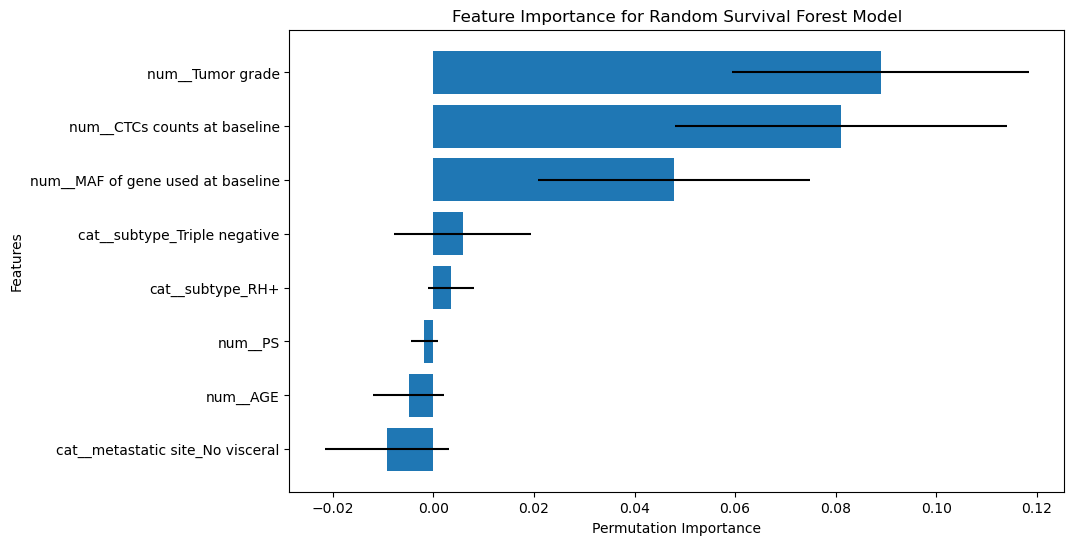

In [75]:
# Calculating feature importance in RSF model
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Verify the input to your model is correctly preprocessed
# This should be done during the pipeline creation and fitting

# Calculate Permutation Importance on the actual input to the model
result = permutation_importance(
    pipeline,  # The fitted pipeline
    X_test,    # The test set features as input to the pipeline
    y_test,    # The test set target
    n_repeats=10,  # Number of times to shuffle a feature
    random_state=42,  # Random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Step 2: Check the number of features used by the model
importances_length = len(result.importances_mean)
print(f"Number of features considered by model: {importances_length}")

# Step 3: If feature names from preprocessor exceed those in model importance, adjust the feature names accordingly
# Get only the names of the features that were actually used by the model
feature_names_used_by_model = pipeline.named_steps['preprocessor'].get_feature_names_out()[:importances_length]

# Step 4: Create the DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_used_by_model,
    'Importance': result.importances_mean,
    'Importance Std': result.importances_std
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame with feature importance
print(feature_importance_df)

# Optional: Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], xerr=feature_importance_df['Importance Std'])
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Random Survival Forest Model')
plt.gca().invert_yaxis()
plt.show()

---

# Comparison Between Other Statistical Models

### Cox Proportional Hazard Model

In [76]:
from lifelines import CoxPHFitter

<lifelines.CoxPHFitter: fitted with 144 total observations, 38 right-censored observations>
             duration col = 'OS at baseline'
                event col = 'Status OS'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 106
   partial log-likelihood = -434.17
         time fit was run = 2024-09-03 21:01:11 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
AGE                            0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
PS                            -0.09       0.91       0.21            -0.51             0.32                 0.60                 1.38
CTCs counts at baseline        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MAF of gene used at baseline   0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
Tumor grade                    0.22       1.25       0.15            -0.06             0.51                 0.94                 1.67
N of met. Sites numeric        0.18       1.20       0.23            -0.27             0.62                 0.77                 1.87
subtype_Triple negative        0.92       2.50       0.24             0.44             1.39                 1.55                 4.03
metastatic site_Visceral       0.08       1.09       0.27            -0.45             0.61                 0.64                 1.85

                               cmp to     z      p   -log2(p)
covariate                                                    
AGE                              0.00  0.64   0.52       0.95
PS                               0.00 -0.44   0.66       0.60
CTCs counts at baseline          0.00  0.54   0.59       0.76
MAF of gene used at baseline     0.00  5.14 <0.005      21.82
Tumor grade                      0.00  1.53   0.13       2.99
N of met. Sites numeric          0.00  0.79   0.43       1.22
subtype_Triple negative          0.00  3.77 <0.005      12.56
metastatic site_Visceral         0.00  0.31   0.76       0.40
---
Concordance = 0.71
Partial AIC = 884.34
log-likelihood ratio test = 56.18 on 8 df
-log2(p) of ll-ratio test = 28.52

Test set concordance index score: 0.7610


<Axes: xlabel='log(HR) (95% CI)'>

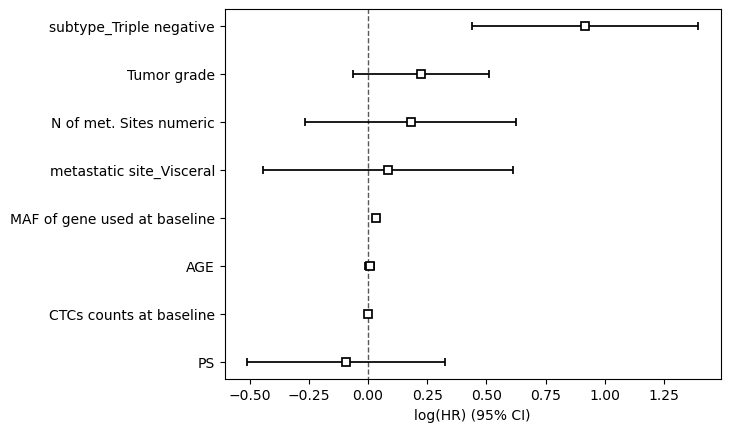

In [77]:
# Comparison between other statisitcical models
# Cox Proportional Hazard Model
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
import pandas as pd

# Select features and target
features = df[['AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline', 'subtype', 'metastatic site', 'Tumor grade', 'N of met. Sites numeric']]
target = df[['Status OS', 'OS at baseline']]

# Combine features and target into one DataFrame for fitting the model
data = pd.concat([features, target], axis=1)

# Encode categorical variables
# Note: Ensure that 'subtype' and 'metastatic site' are categorical in your data. 
# You may need to convert them to category type if they are not.
data['subtype'] = data['subtype'].astype('category')
data['metastatic site'] = data['metastatic site'].astype('category')
# data['Mutation'] = data['Mutation'].astype('category')

# Use pd.get_dummies to one-hot encode categorical variables
data = pd.get_dummies(data, columns=['subtype', 'metastatic site'], drop_first=True)

# Split data into training and testing sets (80% train, 20% test)
train_data_cox, test_data_cox = train_test_split(data, test_size=0.2, random_state=10)

# Initialize CoxPHFitter
cph = CoxPHFitter()

# Fit the model
cph.fit(train_data_cox, duration_col='OS at baseline', event_col='Status OS')

# Print summary of the model
cph.print_summary()

# Evaluate the model's performance on the test set using concordance index
test_predictions = cph.predict_partial_hazard(test_data_cox)  # Predict partial hazard on test set

# Calculate the concordance index for the test set
c_index_cox = concordance_index(test_data_cox['OS at baseline'], -test_predictions, test_data_cox['Status OS'])

print(f'Test set concordance index score: {c_index_cox:.4f}')

# Plot the survival function for a set of covariates
cph.plot()

# Cox PH Model Accuracy Score: 76.10%